This notebook attempts to port results from: https://www.tandfonline.com/doi/abs/10.1080/00949655.2016.1139582?journalCode=gscs20

as in: https://github.com/cran/MonoPoly/

In [6]:
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [157]:
# Residual sum of squares

def make_rss(x, y, alpha=1, w=None):
    """
    Construct the objective function (residual sum of squares)
    """
    
    if w is None:
        w = np.ones_like(x)
        
    def rss(p0):    
        fit = eval_pol_sos(x, p0, alpha)
        return np.sum(w*(y - fit)**2) + np.sum(p0)**2
    
    return rss

def eval_pol_sos(x, p0, alpha=1):
    """
    Evaluate the poylnomial with coefficients p0
    
    """
    beta = eval_coef_sos(p0, alpha)
    return eval_pol(x, beta)

def eval_coef_sos(p0, alpha=1):
    """
    Convert objective function coefficients to beta notation (split polynomial)
    
    """
    assert len(p0) > 3
    
    delta = p0[0]
    degree = (len(p0)-1)//2
    
    if degree == 0:
        res = [delta, alpha*p0[1]]
    else:        
        beta_1 = p0[1:degree+1]
        beta_2 = p0[degree+1:]
        
        assert len(beta_1) == len(beta_2)
        
        res = np.convolve(beta_1, beta_1[::-1], mode="same")
        res += np.convolve(beta_2, beta_2[::-1], mode="same")
        
        res = alpha*res/np.arange(1,len(res)+1)
    
    return res

def eval_pol(x, p0):
    res = 0
    for p in p0[::-1]:
        res = res*x + p
        
    return res

In [158]:
def make_grad(x, y, alpha=1, w=None):
    """
    Returns the gradient of the objective function
    for (x, y) with respect to parameters theta
    
    """
    
    if w is None:
        w = np.ones_like(x)
        
    def grad(p0):
        grad = eval_grad_pol_sos(x, p0, alpha)
        fit = eval_pol_sos(x, p0)
        temp = -2*w*(y - fit)
        
        return np.sum(grad*temp.reshape((-1,1)), axis=0)
    
    return grad

def eval_grad_pol_sos(x, p0, alpha=1):
    """
    Computes the gradient vector
    
    """
    coeff = eval_grad_coeff_sos(p0, alpha)
    res = np.zeros((len(x), len(coeff)+1))
    
    # Gradient with respect to delta is always 1
    res[:,0] = 1
    
    for i, c in enumerate(coeff):
        pc = c
        order = len(c)-1
        tmp = pc[order]*x
        
        for j in range(order,0):
            tmp = (tmp + pc[j])*x
        
        # Gradient with respect to theta_i
        res[:, i+1] = tmp
        
    return res
    
def eval_grad_coeff_sos(p0, alpha=1):
    """
    Calculate dp/dtheta
    
    """
    delta = p0[0]
    degree = (len(p0)-1)//2

    res = [0]*2*degree
    
    res[0] = p0[1:1+degree] # Beta 1
    res[degree] = p0[1+degree:] # Beta 2
    
    if degree > 1:
        for i in range(1, degree):
            res[i] = [0] + res[i-1]
            res[i+degree] = [0] + res[degree+i-1]

    for i in range(len(res)):
        res[i] = 2*alpha*np.array(res[i])/np.arange(1, len(res[i])+1)

    return res


def get_jac(x):
    
    def jac(args, alpha=1):
            """
            nb alpha = 1 for monotone increasing
            in the paper degree = ql
            """

            # define args = delta, beta_1, beta_2
            delta = args[0]
            degree = (len(args)-1)//2

            grad_out = [np.ones_like(x)]

            for l in [1,2]:
                for j in range(degree):
                    _grad = np.zeros_like(x, dtype='float64')
                    for k in range(degree):
                        pow_x = np.power(x, (j+k+1)) / (k+j+1)
                        _grad += args[l*k]*pow_x
                    grad_out.append(2*alpha*_grad)

            return np.array(grad_out)

    return jac

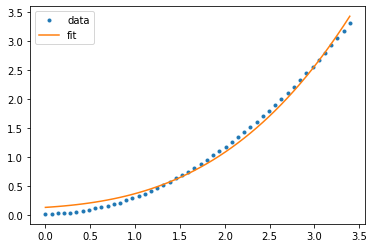

In [160]:
x = np.arange(50)
degree = 4

a = 20
b = 2*np.random.random()
c = 3*np.random.random()

y = a + b*x + c*x**2 + 25*np.random.random((len(x)))

norm_x = x / x.std()
norm_y = y / y.std()

objective_func = make_rss(norm_x, norm_y)
grad = make_grad(norm_x, norm_y)

p0 = np.ones(2*degree+1)
p0[0] = 0.5

res = minimize(objective_func, method='Newton-CG', x0=p0, jac=grad)

plt.plot(norm_x, norm_y, ".", label='data')
plt.plot(norm_x, eval_pol_sos(norm_x, res.x), label='fit')
plt.legend()

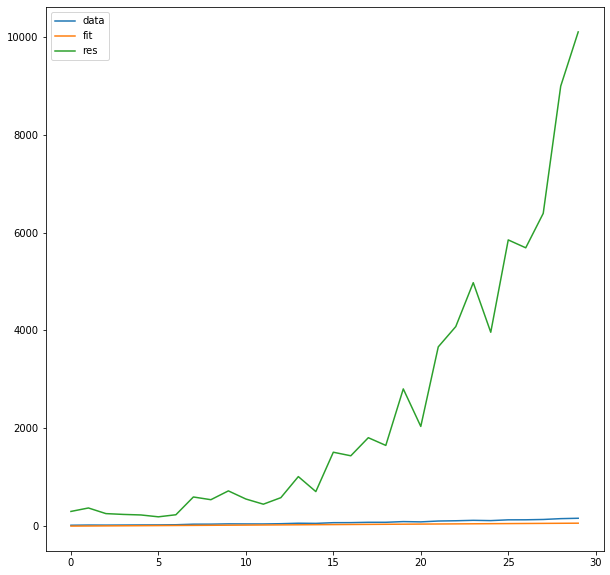

In [15]:
delta = 0 # zero
c10 = 0
c11 = math.sqrt(2)
c21 = 0
c22 = math.sqrt(2.1)

p0 = [delta, c10, c11, c21, c22]

grad = make_grad(x, y)
rss = make_rss(x, y)

plt.figure(figsize=(10,10))
plt.plot(x, y, label='data')
plt.plot(x, eval_pol_sos(x, p0), label='fit')
plt.plot((y-eval_pol_sos(x, p0))**2, label='res')
plt.legend()

In [ ]:
grad(p0)

In [ ]:
eval_grad_coeff_sos(p0)